In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
df=pd.read_csv('df_jepx_spotsum.csv',usecols=[0,7])

# # Ensure DATETIME is in datetime format and sort the data
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME', inplace=True)

# We focus only on the SYSTEM_PRICE for the LSTM model
prices = df['SYSTEM_PRICE'].values.reshape(-1, 1)


In [2]:
NP = prices

In [3]:
df

,SYSTEM_PRICE
DATETIME,
2005-04-02 00:00:00,6.71
2005-04-02 00:30:00,6.65
2005-04-02 01:00:00,6.39
2005-04-02 01:30:00,6.39
2005-04-02 02:00:00,5.68
...,...
2023-11-01 21:30:00,13.91
2023-11-01 22:00:00,13.14
2023-11-01 22:30:00,12.75


In [4]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
sequence_length = 1

In [6]:
X, y = create_sequences(NP, sequence_length)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
y_test

array([[15.81],
       [14.52],
       [ 6.  ],
       ...,
       [ 6.76],
       [ 6.24],
       [ 7.14]])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM modelm
model = Sequential()                    
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# Due to resource limitations, we will limit the number of epochs and batch size
history = model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_test, y_test))

# Summarize the model's architecture
model.summary()



Epoch 1/2

4073/4073 [==============================] - 23s 5ms/step - loss: 10.4139 - val_loss: 5.8316
Epoch 2/2
4073/4073 [==============================] - 17s 4ms/step - loss: 5.6420 - val_loss: 3.1543
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                              

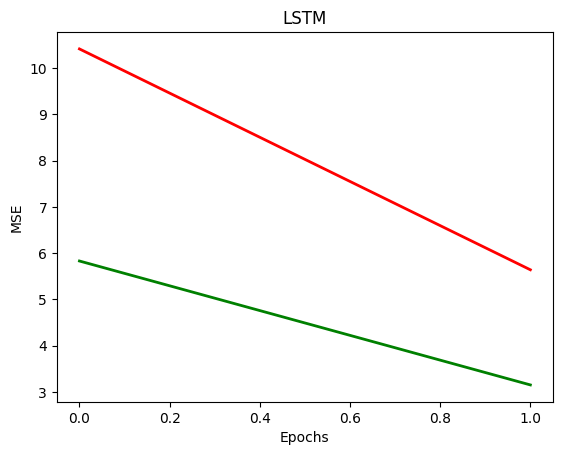

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [11]:
predicted_prices = model(X_test)

In [12]:
predicted_prices

<tf.Tensor: shape=(65165, 1), dtype=float32, numpy=
array([[13.902445 ],
       [12.158725 ],
       [ 6.0685167],
       ...,
       [ 6.7545366],
       [ 6.3492985],
       [ 7.1291914]], dtype=float32)>

In [13]:
y_test

array([[15.81],
       [14.52],
       [ 6.  ],
       ...,
       [ 6.76],
       [ 6.24],
       [ 7.14]])

In [14]:
from sklearn.metrics import r2_score
R2=r2_score(predicted_prices, y_test)
R2

0.9431715423863982

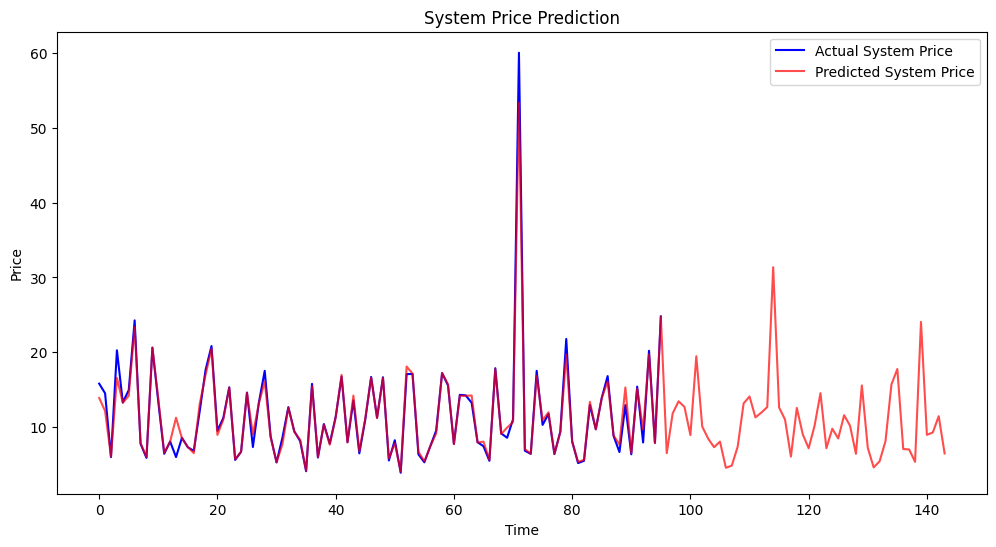

In [15]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test[:96], color='blue', label='Actual System Price')
plt.plot(predicted_prices[:144], color='red', alpha=0.7, label='Predicted System Price')
plt.title('System Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [39]:
y_test_df = pd.DataFrame(y_test, columns=['SYSTEM_PRICE'])

In [36]:
model(X_test[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[13.902445]], dtype=float32)>

In [37]:
y_test[:1]

array([[15.81]])

In [40]:
y_test_df[:1]

,SYSTEM_PRICE
0,15.81


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28944\2482227656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_df['signal'].iloc[i] = -1  # Sell signal
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28944\2482227656.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_df['signal'].iloc[i] = 1  # Buy signal
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28944\2482227656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

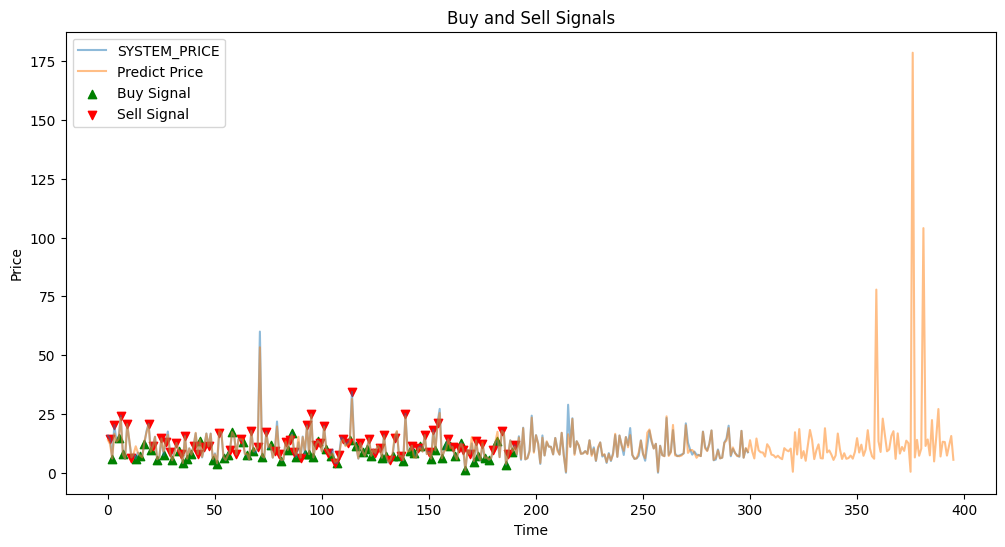

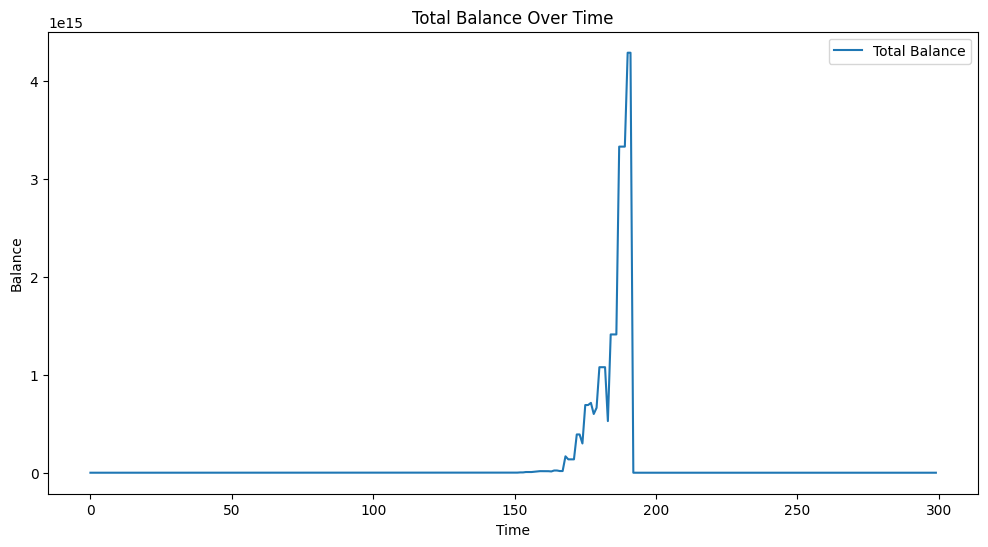

In [42]:
import matplotlib.pyplot as plt

# Generate signals
y_test_df.loc[:, 'signal'] = 0
previous_signal = 0
predicted_prices = model(X_test)
# predict = tf.reshape(predicted_prices, [-1])

for i in range(1, len(y_test_df[:192])):
    if predicted_prices[i+96] > y_test_df['SYSTEM_PRICE'].iloc[i] and previous_signal != 1:
        y_test_df['signal'].iloc[i] = 1  # Buy signal
    elif predicted_prices[i+96] < y_test_df['SYSTEM_PRICE'].iloc[i] and previous_signal != -1:
        y_test_df['signal'].iloc[i] = -1  # Sell signal
    previous_signal = y_test_df['signal'].iloc[i]

# Initialize balance and position tracking
initial_balance = 10000  # Starting balance in dollars
balance = initial_balance
position = 0  # Current position
y_test_df['balance'] = initial_balance

# Backtest the strategy
for i in range(1, len(y_test_df[:192])):
    if y_test_df['signal'][i] == 1 and position <= 0:
        # Buy
        position += balance / y_test_df['SYSTEM_PRICE'][i]
        balance = 0
    elif y_test_df['signal'][i] == -1 and position > 0:
        # Sell
        balance += position * y_test_df['SYSTEM_PRICE'][i]
        position = 0
    y_test_df['balance'][i] = balance + position * y_test_df['SYSTEM_PRICE'][i]

# Plot Buy/Sell Signals on Price
plt.figure(figsize=(12, 6))
plt.plot(y_test_df['SYSTEM_PRICE'][:300], label='SYSTEM_PRICE', alpha=0.5)
plt.plot(predicted_prices[:396], label='Predict Price', alpha=0.5)
plt.scatter(y_test_df.loc[y_test_df['signal'] == 1].index, y_test_df.loc[y_test_df['signal'] == 1]['SYSTEM_PRICE'], label='Buy Signal', marker='^', color='green')
plt.scatter(y_test_df.loc[y_test_df['signal'] == -1].index, y_test_df.loc[y_test_df['signal'] == -1]['SYSTEM_PRICE'], label='Sell Signal', marker='v', color='red')
plt.title('Buy and Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Plot Total Balance Over Time
plt.figure(figsize=(12, 6))
plt.plot(y_test_df['balance'][:300], label='Total Balance')
plt.title('Total Balance Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()

plt.show()


In [43]:
y_test_df["SYSTEM_PRICE"]

0        15.81
1        14.52
2         6.00
3        20.26
4        13.30
         ...  
65160    15.43
65161    16.35
65162     6.76
65163     6.24
65164     7.14
Name: SYSTEM_PRICE, Length: 65165, dtype: float64

In [44]:
predicted_prices

<tf.Tensor: shape=(65165, 1), dtype=float32, numpy=
array([[13.902445 ],
       [12.158725 ],
       [ 6.0685167],
       ...,
       [ 6.7545366],
       [ 6.3492985],
       [ 7.1291914]], dtype=float32)>

In [45]:
y_test_df['balance'].tail(1)


65164    10000.0
Name: balance, dtype: float64